<a href="https://colab.research.google.com/github/livjab/DS3-Kaggle-Comptetion/blob/master/LJ_DS3_Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [5]:
test = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/test_features.csv")
train = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_features.csv")
train_y = pd.read_csv("https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/train_labels.csv")

train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [0]:
train.shape, train_y.shape, test.shape

((59400, 40), (59400, 2), (14358, 40))

In [0]:
train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [0]:
# fast first baseline

train_y["status_group"].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [6]:
# going to combine train_y with train for ease

train = pd.merge(train, train_y)
train.shape

(59400, 41)

In [0]:
# starting with a simple logistic regression model using only numeric columns
# and simple inputer to handle nulls

numeric_columns = train.select_dtypes(include="number").columns
numeric_columns.tolist()

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

features = numeric_columns
target = "status_group"

X_train = train[features]
y_train = train[target]
X_test = test[features]

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

log_reg = LogisticRegression(solver="lbfgs")
log_reg.fit(X_train_imputed, y_train)

log_reg.score(X_train_imputed, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.550993265993266

In [0]:
# going to submit baseline

y_pred = log_reg.predict(X_test_imputed)

sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-first-submission.csv', index=False)
files.download('LJ-first-submission.csv')

In [0]:
# let's up the ante with xgboost classifier

from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

scores = cross_validate(XGBClassifier(max_depth=8, n_estimators=100),
                       X_train_imputed,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)


In [0]:
boost = XGBClassifier(max_depth=8, n_estimators=100)
boost.fit(X_train_imputed, y_train)

y_pred = boost.predict(X_test_imputed)

In [0]:
sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-second-submission.csv', index=False)
files.download('LJ-second-submission.csv')

In [7]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.7MB/s 


In [0]:
# Would like to create a model that includes all features, and then drop the least
# important from there.

# Will need to do some serious cleaning/encoding of categorical features

In [0]:
# drop "id" because it is random

#X_train = train.drop(columns="id")
#X_test = test.drop(columns="id")

# Making a note to drop this feaure when running my model

In [0]:
train.amount_tsh.isnull().sum()

0

In [0]:
train.date_recorded.dtypes

dtype('O')

In [0]:
train.date_recorded.describe()

count          59400
unique           356
top       2011-03-15
freq             572
Name: date_recorded, dtype: object

In [0]:
train.date_recorded.isnull().sum()

0

In [8]:
# Want to split the date recorded into year, month, and day categories

train["date_recorded_sep"] = train["date_recorded"].str.split("-")
train["date_recorded_sep"].head()

0    [2011, 03, 14]
1    [2013, 03, 06]
2    [2013, 02, 25]
3    [2013, 01, 28]
4    [2011, 07, 13]
Name: date_recorded_sep, dtype: object

In [0]:
train["year_recorded"] = train["date_recorded_sep"].str[0]
train["month_recorded"] = train["date_recorded_sep"].str[1]
train["day_of_month_recorded"] = train["date_recorded_sep"].str[2]


In [0]:
# Let's turn these into numeric columns

train["year_recorded"] = pd.to_numeric(train["year_recorded"])
train["month_recorded"] = pd.to_numeric(train["month_recorded"])
train["day_of_month_recorded"] = pd.to_numeric(train["day_of_month_recorded"])

In [0]:
# same for test set

test["date_recorded_sep"] = test["date_recorded"].str.split("-")

test["year_recorded"] = test["date_recorded_sep"].str[0]
test["month_recorded"] = test["date_recorded_sep"].str[1]
test["day_of_month_recorded"] = test["date_recorded_sep"].str[2]

test["year_recorded"] = pd.to_numeric(test["year_recorded"])
test["month_recorded"] = pd.to_numeric(test["month_recorded"])
test["day_of_month_recorded"] = pd.to_numeric(test["day_of_month_recorded"])


In [0]:
train = train.drop(columns="date_recorded_sep")
test = test.drop(columns="date_recorded_sep")

In [13]:
train.shape, test.shape

((59400, 44), (14358, 43))

In [0]:
train.funder.value_counts()

In [0]:
train.funder.isnull().sum()

3635

In [0]:
train["funder"] = train.funder.fillna(value="Government Of Tanzania")
test["funder"] = test.funder.fillna(value="Government of Tanzania")

In [0]:
import category_encoders as ce

X_train = train.drop(columns=["status_group", "date_recorded"])
y_train = train["status_group"]
X_test = test.drop(columns="date_recorded")

imputer = SimpleImputer(strategy="most_frequent")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

encoder = ce.BinaryEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


In [0]:
scores = cross_validate(XGBClassifier(max_depth=5, n_estimators=100),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,104.065572,0.700282,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.772273,0.790404
1,103.639979,0.708248,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.775808,0.788763
2,103.109728,0.718316,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.773636,0.792525


In [0]:
boost = XGBClassifier(max_depth=5, n_estimators=100)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)

In [0]:
# third submission

sample_submission = pd.read_csv('https://raw.githubusercontent.com/livjab/DS3-Kaggle-Comptetion/master/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred

from google.colab import files
submission.to_csv('LJ-third-submission.csv', index=False)
files.download('LJ-third-submission.csv')

In [0]:
!pip install xgboost --upgrade

     |████████████████████████████████| 142.8MB 602kB/s 
  Found existing installation: xgboost 0.82
    Uninstalling xgboost-0.82:
      Successfully uninstalled xgboost-0.82


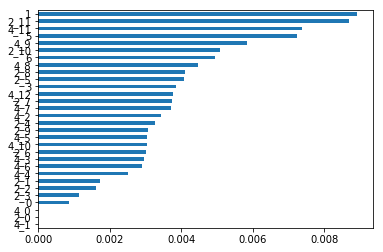

In [0]:
importances = pd.Series(boost.feature_importances_, X_train.columns)
top_n = importances.head(30).sort_values(ascending=True)
top_n.plot.barh();

In [0]:
# well thats really unhelpful after binary encoding changed all my column names

# gonna go back and try to continue encoding each feature in a way that allows
# it to maintain its column name

In [0]:
train.installer.value_counts()

In [0]:
# best / easiest to drop this column from model due to high cardinality

In [0]:
train.wpt_name.value_counts()

In [0]:
# going to exclude this column also

In [0]:
train.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [0]:
train.basin.isnull().sum()

0

In [17]:
# this feature is a good option to use one hot encoding
import category_encoders as ce

oh_encoder = ce.OneHotEncoder(use_cat_names=True)
basin_encoded = oh_encoder.fit_transform(train[["basin"]])
test_encoded = oh_encoder.transform(test[["basin"]])

basin_encoded.head()


,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0


In [0]:
train = pd.concat([train, basin_encoded], axis=1)
test = pd.concat([test, test_encoded], axis=1) 

In [0]:
train.subvillage.value_counts()

In [0]:
# not going to include this one

In [0]:
train.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [19]:
# another good one to use one hot encoding

oh_encoder = ce.OneHotEncoder(use_cat_names=True)
region_encoded = oh_encoder.fit_transform(train[["region"]])
test_encoder = oh_encoder.transform(test[["region"]])

region_encoded.head()

,region_Iringa,region_Mara,region_Manyara,region_Mtwara,region_Kagera,region_Tanga,region_Shinyanga,region_Tabora,region_Pwani,region_Ruvuma,region_Kilimanjaro,region_Rukwa,region_Mwanza,region_Kigoma,region_Lindi,region_Dodoma,region_Arusha,region_Mbeya,region_Singida,region_Morogoro,region_Dar es Salaam
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train = pd.concat([train, region_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)

In [0]:
train.lga.value_counts()

In [0]:
# DROP IT

In [0]:
train.ward.value_counts()

In [0]:
# BYE

In [0]:
train.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [0]:
train.public_meeting.isnull().sum()

3334

In [0]:
train["public_meeting"] = train.public_meeting.fillna(value="True")
train["public_meeting"] = train.public_meeting.astype(bool).astype(int)

In [0]:
test["public_meeting"] = test.public_meeting.fillna(value="True")
test["public_meeting"] = test.public_meeting.astype(bool).astype(int)

In [0]:
train.public_meeting.value_counts()

1    54345
0     5055
Name: public_meeting, dtype: int64

In [0]:
test.public_meeting.value_counts()

1    13093
0     1265
Name: public_meeting, dtype: int64

In [0]:
train.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [0]:
test.recorded_by.value_counts()

GeoData Consultants Ltd    14358
Name: recorded_by, dtype: int64

In [0]:
# can drop this feature entirely as it is not adding anything

train = train.drop(columns="recorded_by")
test = test.drop(columns="recorded_by")

In [24]:
train.shape, test.shape

((59400, 73), (14358, 72))

In [0]:
train.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [0]:
train.scheme_management.isnull().sum()

3877

In [0]:
train.scheme_management = train.scheme_management.fillna(value="None")
test.scheme_management = test.scheme_management.fillna(value="None")

In [0]:
train.scheme_management.isnull().sum()

0

In [26]:
# lets one hot this baby

oh_encoder = ce.OneHotEncoder(use_cat_names=True)
scheme_encoded = oh_encoder.fit_transform(train[["scheme_management"]])
test_encoder = oh_encoder.transform(test[["scheme_management"]])

scheme_encoded.head()

,scheme_management_VWC,scheme_management_Other,scheme_management_None,scheme_management_Private operator,scheme_management_WUG,scheme_management_Water Board,scheme_management_WUA,scheme_management_Water authority,scheme_management_Company,scheme_management_Parastatal,scheme_management_Trust,scheme_management_SWC
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0


In [0]:
train = pd.concat([train, scheme_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)

In [0]:
train.scheme_name.value_counts()

In [0]:
# get outta heeeere

In [0]:
train.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [0]:
train.permit.isnull().sum()

3056

In [0]:
train.permit = train.permit.fillna(value="True")
train.permit = train.permit.astype(bool).astype(int)

In [0]:
test.permit = test.permit.fillna(value="True")
test.permit = test.permit.astype(bool).astype(int)

In [0]:
train.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [0]:
train.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [0]:
train.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [0]:
train.extraction_type_class.isnull().sum()

0

In [30]:
# since these three have a lot of similarities, going to use only the last one
# and one hot encode it

oh_encoder = ce.OneHotEncoder(use_cat_names=True)
extraction_encoded = oh_encoder.fit_transform(train[["extraction_type_class"]])
test_encoder = oh_encoder.transform(test[["extraction_type_class"]])

extraction_encoded.head()


,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0


In [0]:
train = pd.concat([train, extraction_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)

In [32]:
test.shape, train.shape

((14358, 91), (59400, 92))

In [33]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'year_recorded', 'month_recorded',
       'day_of_month_recorded', 'basin_Lake Nyasa', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Ruvuma / Southern Coast', 'basin_Internal',
       'basin_Lake Tanganyika', 'basin_Wami / Ruvu', 'basin_Rufiji',
       'basin_Lake Rukwa', 'region_Iringa', 'region_Mara', 'region_Manyara',

In [0]:
# want to get a final submission in today

features = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code',
       'population', 'public_meeting', 'permit', 'construction_year', 'year_recorded',
       'month_recorded', 'day_of_month_recorded', 'basin_Lake Nyasa',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Ruvuma / Southern Coast',
       'basin_Internal', 'basin_Lake Tanganyika', 'basin_Wami / Ruvu',
       'basin_Rufiji', 'basin_Lake Rukwa', 'region_Iringa', 'region_Mara',
       'region_Manyara', 'region_Mtwara', 'region_Kagera', 'region_Tanga',
       'region_Shinyanga', 'region_Tabora', 'region_Pwani', 'region_Ruvuma',
       'region_Kilimanjaro', 'region_Rukwa', 'region_Mwanza', 'region_Kigoma',
       'region_Lindi', 'region_Dodoma', 'region_Arusha', 'region_Mbeya',
       'region_Singida', 'region_Morogoro', 'region_Dar es Salaam',
       'scheme_management_VWC', 'scheme_management_Other',
       'scheme_management_None', 'scheme_management_Private operator',
       'scheme_management_WUG', 'scheme_management_Water Board',
       'scheme_management_WUA', 'scheme_management_Water authority',
       'scheme_management_Company', 'scheme_management_Parastatal',
       'scheme_management_Trust', 'scheme_management_SWC']
target = "status_group"

X_train = train[features]
y_train = train[target]
X_test = test[features]

scores = cross_validate(XGBClassifier(max_depth=7, n_estimators=100),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,45.016488,0.527241,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.705505,0.745025
1,44.505869,0.516633,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.704545,0.741111
2,44.941952,0.527607,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.701869,0.748535


In [0]:
boost = XGBClassifier(max_depth=5, n_estimators=100)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)

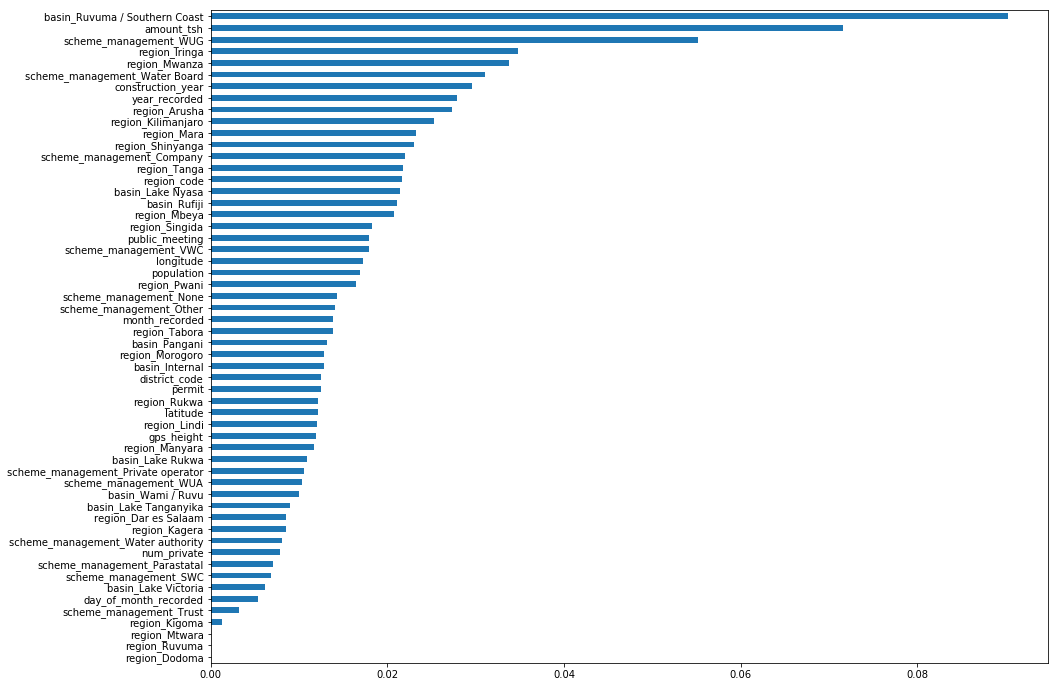

In [0]:
import matplotlib.pyplot as plt

importances = pd.Series(boost.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=True)
plt.figure(figsize=(15,12))
top_n.plot.barh();

In [0]:
# well at least I have column names this time. 
# going to continue with the rest of the features 

In [34]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,...,region_Iringa,region_Mara,region_Manyara,region_Mtwara,region_Kagera,region_Tanga,region_Shinyanga,region_Tabora,region_Pwani,region_Ruvuma,region_Kilimanjaro,region_Rukwa,region_Mwanza,region_Kigoma,region_Lindi,region_Dodoma,region_Arusha,region_Mbeya,region_Singida,region_Morogoro,region_Dar es Salaam,scheme_management_VWC,scheme_management_Other,scheme_management_None,scheme_management_Private operator,scheme_management_WUG,scheme_management_Water Board,scheme_management_WUA,scheme_management_Water authority,scheme_management_Company,scheme_management_Parastatal,scheme_management_Trust,scheme_management_SWC,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,1,VWC,Roman,0,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,1,Other,NaN,1,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,1,VWC,Nyumba ya mungu pipe scheme,1,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,1,VWC,NaN,1,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,1,None,NaN,1,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [37]:
train.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [38]:
train.management.isnull().sum()

0

In [0]:
oh_encoder = ce.OneHotEncoder(use_cat_names=True)
managemento_encoded = oh_encoder.fit_transform(train[["management"]])
test_encoder = oh_encoder.transform(test[["management"]])

train = pd.concat([train, managemento_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)


In [35]:
train.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [39]:
train.management_group.isnull().sum()

0

In [0]:
# one hot

oh_encoder = ce.OneHotEncoder(use_cat_names=True)
management_encoded = oh_encoder.fit_transform(train[["management_group"]])
test_encoder = oh_encoder.transform(test[["management_group"]])

train = pd.concat([train, management_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)


In [41]:
train.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [42]:
train.payment.isnull().sum()

0

In [0]:
oh_encoder = ce.OneHotEncoder(use_cat_names=True)
payment_encoded = oh_encoder.fit_transform(train[["payment"]])
test_encoder = oh_encoder.transform(test[["payment"]])

train = pd.concat([train, payment_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)


In [44]:
train.shape, test.shape

((59400, 116), (14358, 115))

In [45]:
train.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [0]:
# same exact thing, lets drop this

train = train.drop(columns="payment_type")
test = test.drop(columns="payment_type")

In [48]:
train.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [49]:
train.water_quality.isnull().sum()

0

In [51]:
train.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [0]:
# lets use quality_group and drop water_quality

In [0]:
oh_encoder = ce.OneHotEncoder(use_cat_names=True)
quality_encoded = oh_encoder.fit_transform(train[["quality_group"]])
test_encoder = oh_encoder.transform(test[["quality_group"]])

train = pd.concat([train, quality_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)

In [53]:
train.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [55]:
train.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [0]:
# same stuff -- lets use quantity and try ordinal encoding this time

train.quantity = train.quantity.replace({"enough": 4, "insufficient": 3, 
                                         "dry": 2, "seasonal": 1, "unknown": 0})

test.quantity = test.quantity.replace({"enough": 4, "insufficient": 3, 
                                         "dry": 2, "seasonal": 1, "unknown": 0})

In [56]:
train.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [60]:
train.source.isnull().sum()

0

In [57]:
train.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [61]:
train.source_type.isnull().sum()

0

In [0]:
# lets use source_type as there a slightly fewer options for one hot

oh_encoder = ce.OneHotEncoder(use_cat_names=True)
source_encoded = oh_encoder.fit_transform(train[["source_type"]])
test_encoder = oh_encoder.transform(test[["source_type"]])

train = pd.concat([train, source_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)

In [58]:
train.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [63]:
train.source_class.isnull().sum()

0

In [0]:
# I'm thinking I'll go ordinal here 
train.source_class = train.source_class.replace({"groundwater": 2, "surface": 1, "unknown": 0})
test.source_class = test.source_class.replace({"groundwater": 2, "surface": 1, "unknown": 0})


In [64]:
train.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [66]:
train.waterpoint_type.isnull().sum()

0

In [65]:
train.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [0]:
# one hot time -- using waterpoint type

oh_encoder = ce.OneHotEncoder(use_cat_names=True)
waterpoint_encoded = oh_encoder.fit_transform(train[["waterpoint_type"]])
test_encoder = oh_encoder.transform(test[["waterpoint_type"]])

train = pd.concat([train, waterpoint_encoded], axis=1)
test = pd.concat([test, test_encoder], axis=1)

In [68]:
train.shape, test.shape

((59400, 143), (14358, 142))

In [74]:
train.columns.to_list()

['id',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group',
 'year_recorded',
 'month_recorded',
 'day_of_month_recorded',
 'basin_Lake Nyasa',
 'basin_Lake Victoria',
 'basin_Pangani',
 'basin_Ruvuma / Southern Coast',
 'basin_Internal',
 'basin_Lake Tanganyika',
 'basin_Wami / Ruvu',
 'basin_Rufiji',
 'basin_Lake Rukwa',
 'region_Iringa',
 'region_Mara',
 'region_Manyara',
 'region_Mtwara',
 'region_Kagera',
 'region_Tanga',
 'regi

In [77]:
# lets put this mess all together

from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score



features = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code',
       'population', 'public_meeting', 'permit', 'construction_year', 'year_recorded',
       'month_recorded', 'day_of_month_recorded', 'basin_Lake Nyasa',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Ruvuma / Southern Coast',
       'basin_Internal', 'basin_Lake Tanganyika', 'basin_Wami / Ruvu',
       'basin_Rufiji', 'basin_Lake Rukwa', 'region_Iringa', 'region_Mara',
       'region_Manyara', 'region_Mtwara', 'region_Kagera', 'region_Tanga',
       'region_Shinyanga', 'region_Tabora', 'region_Pwani', 'region_Ruvuma',
       'region_Kilimanjaro', 'region_Rukwa', 'region_Mwanza', 'region_Kigoma',
       'region_Lindi', 'region_Dodoma', 'region_Arusha', 'region_Mbeya',
       'region_Singida', 'region_Morogoro', 'region_Dar es Salaam',
       'scheme_management_VWC', 'scheme_management_Other',
       'scheme_management_None', 'scheme_management_Private operator',
       'scheme_management_WUG', 'scheme_management_Water Board',
       'scheme_management_WUA', 'scheme_management_Water authority',
       'scheme_management_Company', 'scheme_management_Parastatal',
       'scheme_management_Trust', 'scheme_management_SWC', 'extraction_type_class_gravity',
       'extraction_type_class_submersible', 'extraction_type_class_handpump', 
       'extraction_type_class_other', 'extraction_type_class_motorpump',
       'extraction_type_class_wind-powered', 'extraction_type_class_rope pump',
       'management_group_user-group', 'management_group_other', 'management_group_commercial',
       'management_group_parastatal', 'management_group_unknown', 'management_vwc',
       'management_wug', 'management_other', 'management_private operator',
       'management_water board', 'management_wua', 'management_company',
       'management_water authority', 'management_parastatal', 'management_unknown',
       'management_other - school', 'management_trust', 'payment_pay annually',
       'payment_never pay', 'payment_pay per bucket', 'payment_unknown',
       'payment_pay when scheme fails', 'payment_other', 'payment_pay monthly',
       'water_quality_soft', 'water_quality_salty', 'water_quality_milky',
       'water_quality_unknown', 'water_quality_fluoride', 'water_quality_coloured',
       'water_quality_salty abandoned', 'water_quality_fluoride abandoned',
       'quality_group_good', 'quality_group_salty', 'quality_group_milky',
       'quality_group_unknown', 'quality_group_fluoride', 'quality_group_colored',
       'source_type_spring', 'source_type_rainwater harvesting', 'source_type_dam',
       'source_type_borehole', 'source_type_other', 'source_type_shallow well',
       'source_type_river/lake', 'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple', 'waterpoint_type_hand pump',
       'waterpoint_type_other', 'waterpoint_type_improved spring',
       'waterpoint_type_cattle trough', 'waterpoint_type_dam']
target = "status_group"

X_train = train[features]
y_train = train[target]
X_test = test[features]

scores = cross_validate(XGBClassifier(max_depth=6, n_estimators=100),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,75.505235,0.499107,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.743838,0.763662
1,73.745008,0.468627,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.743586,0.760505
2,73.904927,0.476838,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.739697,0.765808


In [0]:
boost = XGBClassifier(max_depth=6, n_estimators=100)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)

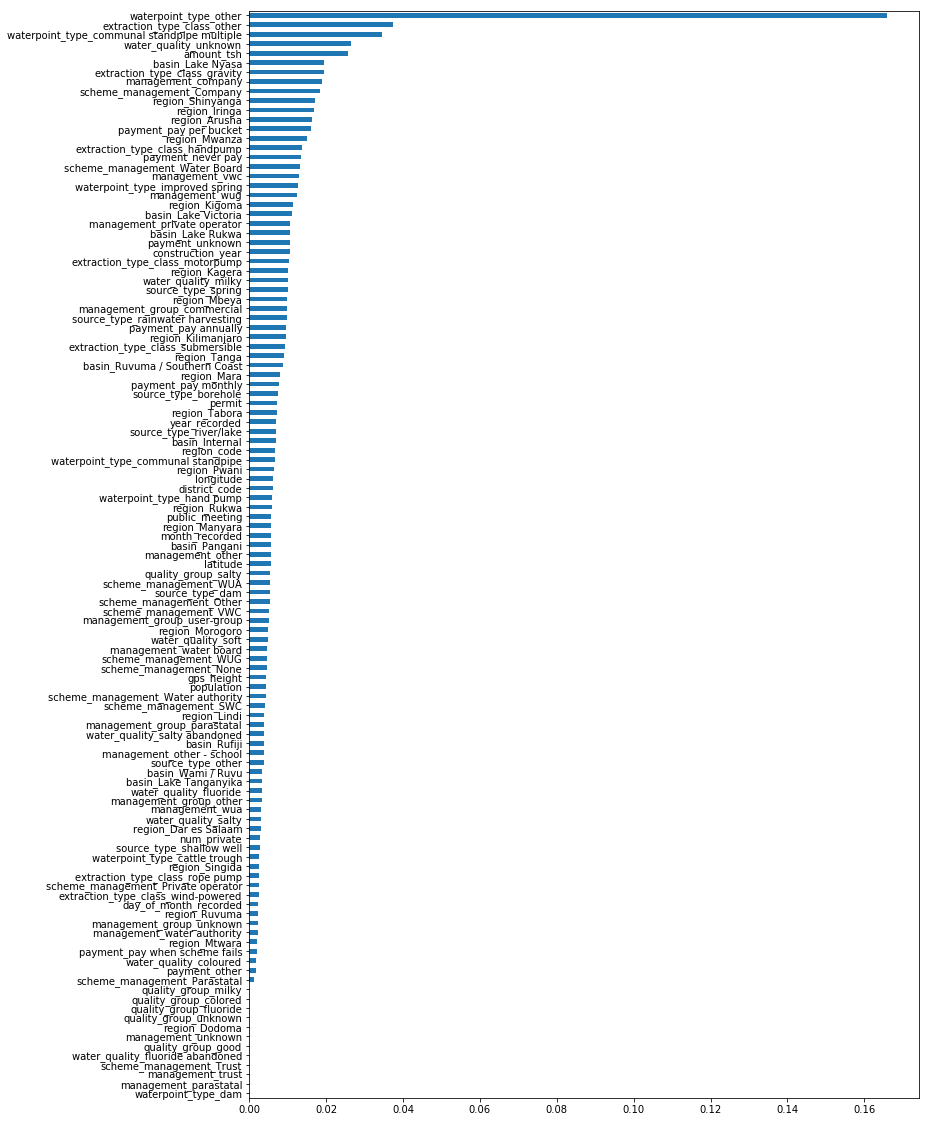

In [81]:
import matplotlib.pyplot as plt

importances = pd.Series(boost.feature_importances_, X_train.columns)
top_n = importances.sort_values(ascending=True)
plt.figure(figsize=(12,20))
top_n.plot.barh();

In [82]:
# lets drop some of those bottom features and run again

features = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code',
       'population', 'public_meeting', 'permit', 'construction_year', 'year_recorded',
       'month_recorded', 'day_of_month_recorded', 'basin_Lake Nyasa',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Ruvuma / Southern Coast',
       'basin_Internal', 'basin_Lake Tanganyika', 'basin_Wami / Ruvu',
       'basin_Rufiji', 'basin_Lake Rukwa', 'region_Iringa', 'region_Mara',
       'region_Manyara', 'region_Mtwara', 'region_Kagera', 'region_Tanga',
       'region_Shinyanga', 'region_Tabora', 'region_Pwani', 'region_Ruvuma',
       'region_Kilimanjaro', 'region_Rukwa', 'region_Mwanza', 'region_Kigoma',
       'region_Lindi', 'region_Arusha', 'region_Mbeya',
       'region_Singida', 'region_Morogoro', 'region_Dar es Salaam',
       'scheme_management_VWC', 'scheme_management_Other',
       'scheme_management_None', 'scheme_management_Private operator',
       'scheme_management_WUG', 'scheme_management_Water Board',
       'scheme_management_WUA', 'scheme_management_Water authority',
       'scheme_management_Company', 'scheme_management_Parastatal',
       'scheme_management_SWC', 'extraction_type_class_gravity',
       'extraction_type_class_submersible', 'extraction_type_class_handpump', 
       'extraction_type_class_other', 'extraction_type_class_motorpump',
       'extraction_type_class_wind-powered', 'extraction_type_class_rope pump',
       'management_group_user-group', 'management_group_other', 'management_group_commercial',
       'management_group_parastatal', 'management_group_unknown', 'management_vwc',
       'management_wug', 'management_other', 'management_private operator',
       'management_water board', 'management_wua', 'management_company',
       'management_water authority',
       'management_other - school', 'payment_pay annually',
       'payment_never pay', 'payment_pay per bucket', 'payment_unknown',
       'payment_pay when scheme fails', 'payment_other', 'payment_pay monthly',
       'water_quality_soft', 'water_quality_salty', 'water_quality_milky',
       'water_quality_unknown', 'water_quality_fluoride', 'water_quality_coloured',
       'water_quality_salty abandoned',
       'quality_group_salty',
       'source_type_spring', 'source_type_rainwater harvesting', 'source_type_dam',
       'source_type_borehole', 'source_type_other', 'source_type_shallow well',
       'source_type_river/lake', 'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple', 'waterpoint_type_hand pump',
       'waterpoint_type_other', 'waterpoint_type_improved spring',
       'waterpoint_type_cattle trough']
target = "status_group"

X_train = train[features]
y_train = train[target]
X_test = test[features]

scores = cross_validate(XGBClassifier(max_depth=6, n_estimators=100),
                       X_train,
                       y_train,
                       scoring="accuracy",
                       cv=3,
                       return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,68.033212,0.467508,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.744646,0.763283
1,67.121159,0.453133,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.742222,0.759167
2,67.124397,0.475768,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.739394,0.765707


In [0]:
# not much of an improvement

# moving on to a different method